# Python for Finance
## Exercises
In order to master the material of this module, do the following:

* replace the S&P 500 index by another symbol, eg. `MSFT.O` or `.SPX`
* work with different SMA values, e.g. 20 and 100
* implement an optimization procedure to come up with optimal SMA values
* implement a backtesting procedure which distinguishes in-sample (training) from out-of-sample (test) data sets
* formalize other trading strategies based on other metrics
* install a dedicated backtesting library like [PyAlgoTrade](http://gbeced.github.io/pyalgotrade/) or [zipline](https://github.com/quantopian/zipline) and do the tutorials

In [44]:
import numpy as np  # array operations
import pandas as pd  # time series management
import matplotlib.pyplot as plt  # standard plotting library
from pylab import plt
plt.style.use('ggplot')
# put all plots in the notebook itself
%matplotlib inline

In [45]:
symbol = 'AAPL.O'
data = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                   index_col=0, parse_dates=True)[symbol].dropna()
data = pd.DataFrame(data)

In [46]:
data.tail(10)

,AAPL.O
Date,
2018-06-18,188.74
2018-06-19,185.69
2018-06-20,186.50
2018-06-21,185.46
2018-06-22,184.92
2018-06-25,182.17
2018-06-26,184.43
2018-06-27,184.16
2018-06-28,185.50


In [47]:
data.describe()

,AAPL.O
count,2138.000000
mean,93.455973
std,40.551559
min,27.435687
25%,60.294225
50%,90.550624
75%,117.235000
max,193.980000


## Generating Trading Signals
We want to implement a **trading strategy based on simple moving averages (SMA)**. We work with two SMAs:

* short-term SMA over 42 days (SMA42)
* long-term SMA over 252 days (SMA252)

We distinguish two constellations:

* SMA42 > SMA252: buy signal, being **long** the market
* SMA42 < SMA252: sell signal, being **short** the market

In [48]:
data['SMA42'] = data[symbol].rolling(window=42).mean()
data['SMA252'] = data[symbol].rolling(window=252).mean()
data.dropna(inplace=True)  # drop rows with NaN values

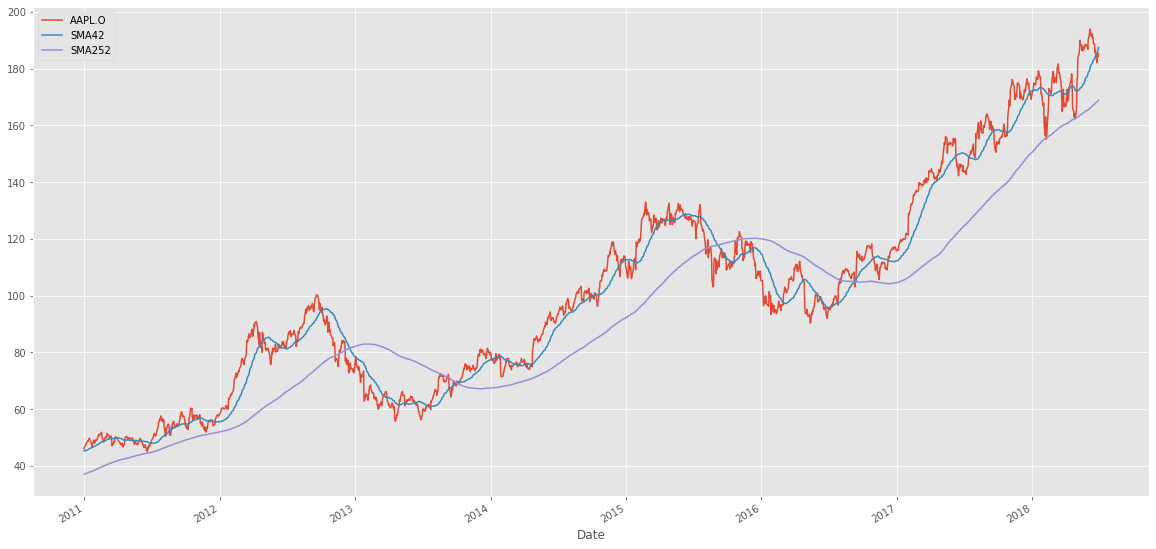

In [49]:
data[[symbol, 'SMA42', 'SMA252']].plot(figsize=(20, 10));

This need to be formalized for the calculations to come. 

We represent **"being long the market" by 1** and **"being short the market" by -1**.

In [50]:
# vectorized evaluation of the trading condition/signal generation
data['position'] = np.where(data['SMA42'] > data['SMA252'], 1, -1)

Let us **visualize the positions** resulting from the signal.

(-1.1, 1.1)

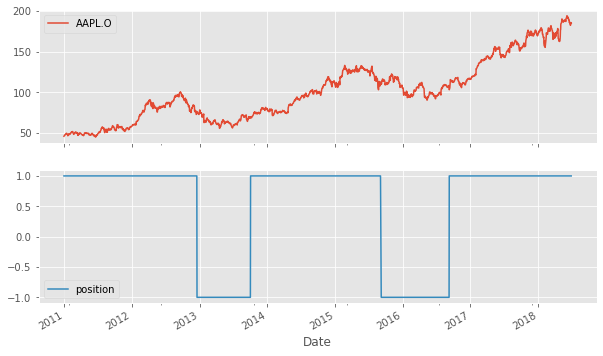

In [51]:
data[[symbol, 'position']].plot(subplots=True, figsize=(10, 6))
plt.ylim(-1.1, 1.1)  # adjust y-axis limits

In [52]:
# vectorized calculation of log returns
data['market'] = np.log(data[symbol] / data[symbol].shift(1))

In [53]:
# vectorized calculation of strategy returns
data['strategy'] = data['position'].shift(1) * data['market']

Next, let us calculate the **cumulative returns** of the market vs. the trading strategy. 

This is straightforward since we work with log returns. We first calculate the cumulative sums (`cumsum`) and the apply the exponential function (`np.exp`) to the respective time series.

In [54]:
data[['market', 'strategy']].cumsum().apply(np.exp).tail()


,market,strategy
Date,,
2018-06-25,3.953346,5.719002
2018-06-26,4.002391,5.789952
2018-06-27,3.996532,5.781475
2018-06-28,4.025612,5.823543
2018-06-29,4.017148,5.811299


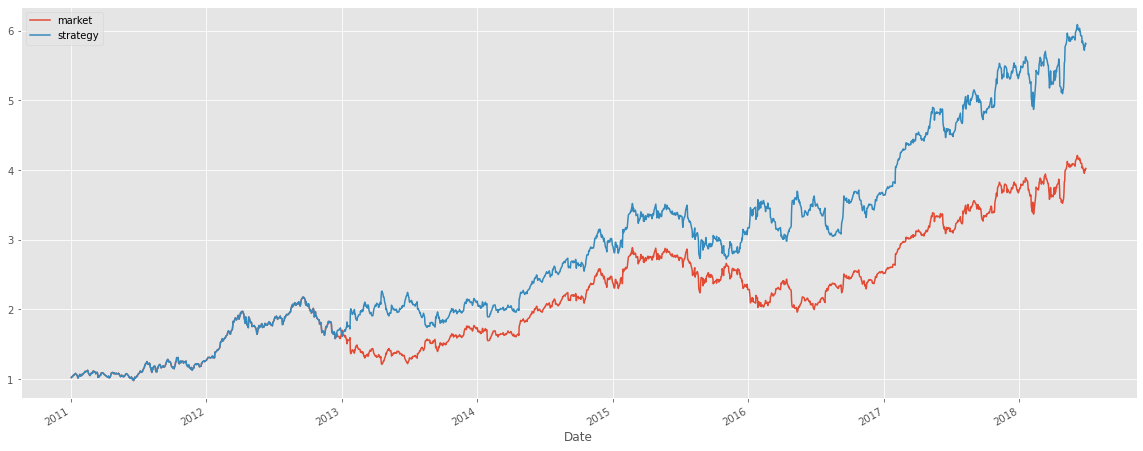

In [55]:
data[['market', 'strategy']].cumsum().apply(np.exp).plot(figsize=(20, 8));

## Risk and Return

Final consideration: what about the relation between **risk & return**? Let us quickly do the math. The **annualized return** of the strategy is obviously higher that from the market ...

In [56]:
print("Annualized Returns")
arets = data[['market', 'strategy']].mean() * 252  # annualized returns
arets

Annualized Returns


market      0.185803
strategy    0.235138
dtype: float64

In [57]:
print("Annualized Vols")
astds = data[['market', 'strategy']].std() * 252 ** 0.5  # annualized volatility
astds

Annualized Vols


market      0.250571
strategy    0.250407
dtype: float64